In [1]:
import logging

import numpy as np
from numba import njit
import matplotlib.pyplot as plt
%matplotlib inline
logging.getLogger().setLevel(logging.INFO)


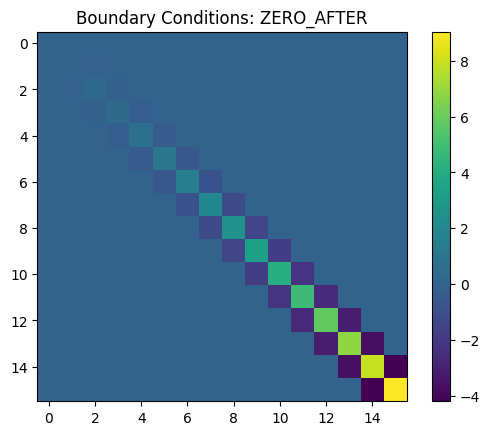

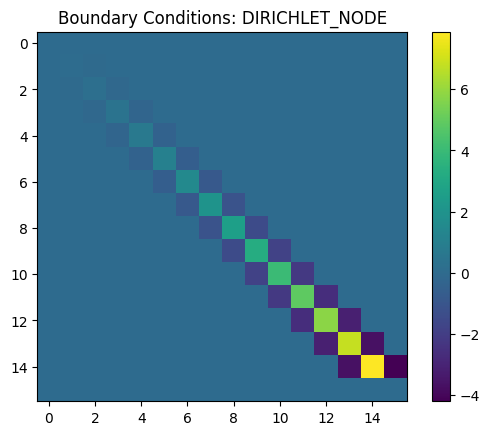

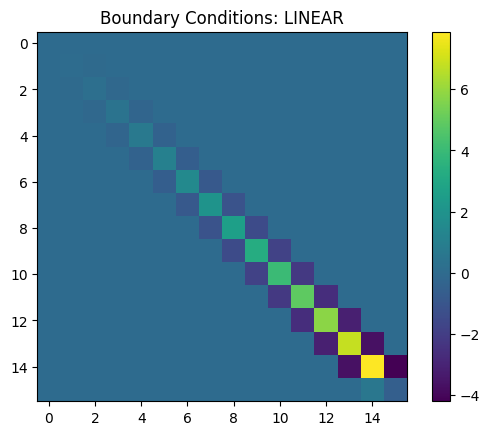

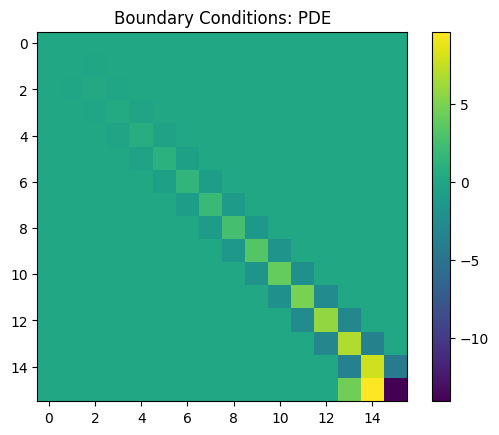

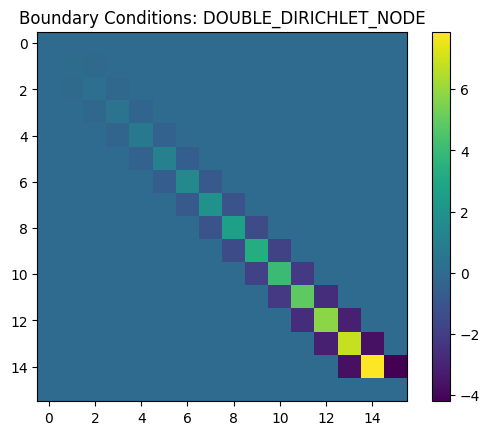

In [6]:
# from tests.black_scholes.hamiltonian import generateBlackScholesHamiltonian
from qnute.hamiltonian import Hamiltonian
from tests.black_scholes import BlackScholesInfo, Basis, BoundaryConditions
from qnute.hamiltonian.examples.position_operator import generatePositionHamiltonian
from qnute.hamiltonian.examples.finite_difference.first_derivative import generateFirstDerivativeHamiltonian1D
from qnute.hamiltonian.examples.finite_difference.laplacian import generateLaplaceHamiltonian1D

from qnute.hamiltonian import hm_list_tensor
from qnute.hamiltonian.construction import get_lowerLeft_hm_list, get_lowerRight_hm_list, get_upperLeft_hm_list

def lowerRightHam(num_qbits:int) -> Hamiltonian:
    return Hamiltonian(get_lowerRight_hm_list(num_qbits), num_qbits)
def lowerRight1Ham(num_qbits:int) -> Hamiltonian:
    assert num_qbits >= 2
    return Hamiltonian(hm_list_tensor(get_lowerRight_hm_list(num_qbits-1), 
                                      get_lowerLeft_hm_list(1) ), num_qbits)
def lowerRight2Ham(num_qbits:int) -> Hamiltonian:
    assert num_qbits >=2
    if num_qbits == 2:
        return Hamiltonian(hm_list_tensor(get_lowerLeft_hm_list(1),
                                          get_lowerRight_hm_list(1) ), num_qbits)
    return Hamiltonian(hm_list_tensor(get_lowerRight_hm_list(num_qbits-2),
                                      hm_list_tensor(get_lowerLeft_hm_list(1),
                                                     get_lowerRight_hm_list(1)) ), num_qbits)


def foo(bs_data:BlackScholesInfo,
                                    num_qbits:int
                                    )->Hamiltonian:
    assert num_qbits >= 2, 'Black Scholes Hamiltonian requries at least two qubits!'
    N = 2**num_qbits
    dS = bs_data.Smax / (N-1)

    if bs_data.basis == Basis.S:
        BSHam = (
            (SHam:=generatePositionHamiltonian(num_qbits, 0, dS)) * generateFirstDerivativeHamiltonian1D(num_qbits, dS) * -(bs_data.r-bs_data.q) 
            + SHam*SHam*generateLaplaceHamiltonian1D(num_qbits, dS)*(-(bs_data.sigma**2)/2) 
            + Hamiltonian.Identity(num_qbits)*(bs_data.r)
            )
        
        match bs_data.BC:
            case BoundaryConditions.ZERO_AFTER:
                pass
            case BoundaryConditions.DIRICHLET_NODE:
                BC_Ham = lowerRightHam(num_qbits) * -(bs_data.r + (bs_data.sigma*bs_data.Smax/dS)**2)
                BC_Ham += lowerRight1Ham(num_qbits) * ((bs_data.sigma*bs_data.Smax/dS)**2 / 2 - (bs_data.r-bs_data.q)*bs_data.Smax/(2*dS))
                BSHam += BC_Ham
            case BoundaryConditions.LINEAR:
                BC_Ham = lowerRightHam(num_qbits) * -((bs_data.sigma*bs_data.Smax/dS)**2 + (bs_data.r-bs_data.q)*bs_data.Smax/dS)
                BC_Ham += lowerRight1Ham(num_qbits) * ((bs_data.sigma*bs_data.Smax/dS)**2 / 2 + (bs_data.r-bs_data.q)*bs_data.Smax/(2*dS))
                BSHam += BC_Ham
            case BoundaryConditions.PDE:
                BC_Ham = lowerRightHam(num_qbits) * ((bs_data.sigma*bs_data.Smax/dS)**2*(-5/2) - (bs_data.r-bs_data.q)*bs_data.Smax/dS)
                BC_Ham += lowerRight1Ham(num_qbits) * ((bs_data.sigma*bs_data.Smax/dS)**2 *(3/2) + (bs_data.r-bs_data.q)*bs_data.Smax/(2*dS))
                BC_Ham += lowerRight2Ham(num_qbits) * ((bs_data.sigma*bs_data.Smax/dS)**2/2)
                BSHam += BC_Ham
            case BoundaryConditions.DOUBLE_DIRICHLET_NODE:
                BC_Ham = lowerRightHam(num_qbits) * -(bs_data.r + (bs_data.sigma*bs_data.Smax/dS)**2)
                BC_Ham += lowerRight1Ham(num_qbits) * ((bs_data.sigma*bs_data.Smax/dS)**2 / 2 - (bs_data.r-bs_data.q)*bs_data.Smax/(2*dS))
                BC_Ham += Hamiltonian(get_upperLeft_hm_list(num_qbits), num_qbits) * (-bs_data.r)
                BSHam += BC_Ham
            case _:
                raise NotImplementedError('These boundary conditions are not yet implemented!')
    else:
        raise NotImplementedError('x-Basis hamiltonian not implemented yet!') 
    
    return BSHam


BSHams = [None] * len(BoundaryConditions)

for i,BC in enumerate(BoundaryConditions):
    # if BC not in [BoundaryConditions.ZERO_AFTER, BoundaryConditions.DIRICHLET_NODE, BoundaryConditions.DOUBLE_DIRICHLET_NODE]:
    #     continue
    bs_data = BlackScholesInfo(r:=0.04, q:=0, sigma:=0.2, basis:=Basis.S, 
                            Smax:=150, BC)
    BSHams[i] = foo(bs_data, n:=4)
    N = 2**n
    dS = Smax/(N-1)

    mmax = r+(sigma*(N-1))**2

    # print(f'Boundary Conditions: {BC.name}')
    # print(f'  |max| = {np.max(np.abs(BSHams[i].get_matrix().real))}')
    # print(f'  {r+(sigma*(N-1))**2}')
    # print(f'  |min| = {np.min(np.abs(BSHam.get_matrix().real))}')
    # print('  spectrum:\n    ',BSHams[i].get_spectrum()[0])
    # print('Eigenvalues:', np.linalg.eig(BSHams[i].get_matrix().real)[0])
    # print('  matrix:\n', BSHam.get_matrix().real)

    # plt.imshow(np.where(np.abs(BSHam.get_matrix().real) > mmax, 1.0, -1.0), vmin=-1.0,vmax=1.0)
    plt.imshow(BSHams[i].get_matrix().real)
    plt.colorbar()
    plt.title(f'Boundary Conditions: {BC.name}')
    plt.show()

In [9]:
BSHams[BoundaryConditions.LINEAR.value].get_matrix().real[-1,:]

array([ 0.  ,  0.  ,  0.  ,  0.  ,  0.  ,  0.  ,  0.  ,  0.  ,  0.  ,
        0.  ,  0.  ,  0.  ,  0.  ,  0.  ,  0.6 , -0.56])

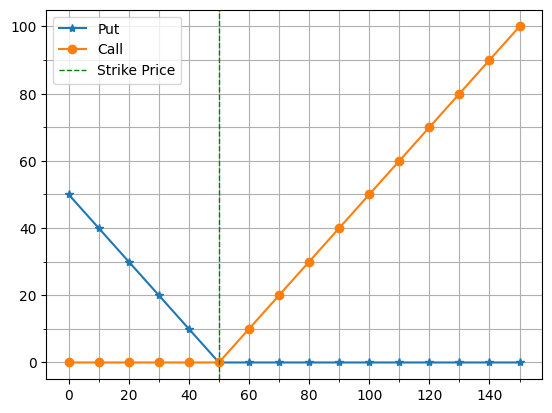

In [4]:
def EuropeanPutState(Smax:float, strike:float, num_qbits:int) -> np.ndarray[float]:
    N = 2**num_qbits
    V = np.zeros(N,np.float64)
    dS = Smax/(N-1)

    V = np.where((S:=np.linspace(0.0,Smax,N)) < strike, strike - S, 0.0)

    # for i in range(N):
    #     if i*dS >= strike:
    #         break
    #     V[i] = strike - i*dS
    return V

def EuropeanCallState(Smax:float, strike:float, num_qbits:int) -> np.ndarray[float]:
    N = 2**num_qbits
    V = np.where((S:=np.linspace(0.0,Smax,N)) > strike, S-strike, 0.0)
    return V

Vput = EuropeanPutState(Smax, K:=50, n)
Vcal = EuropeanCallState(Smax,K,n)
N=2**n
plt.plot(x:=np.linspace(0.0,Smax,N), Vput, marker='*',label='Put')
plt.plot(x:=np.linspace(0.0,Smax,N), Vcal, marker='o',label='Call')
# plt.scatter([K],[0],marker='s',label='Strike')
plt.axvline(x=K,linestyle='dashed', label='Strike Price',color='g',linewidth=1.0)
plt.legend()
# plt.grid(True)
# plt.xticks(x)
# plt.ylim(0.0,Smax)
plt.xticks(np.arange(0,160,10),minor=True)
plt.yticks(np.arange(0,100,10),minor=True)
plt.grid(True,which='both')
plt.show()

In [8]:
from qnute.simulation.numerical_sim import qnute, qnute_logger
from qnute.simulation.parameters import QNUTE_params as Params
qnute_logger.setLevel(logging.INFO)

T = 3
Nt = 1000
dt = T/Nt

psiPut = Vput / (cPut:=np.linalg.norm(Vput))
psiCal = Vcal / (cCal:=np.linalg.norm(Vcal))

solutionsPut = np.zeros((len(BoundaryConditions), Nt+1, N),np.float64)
solutionsCal = np.zeros((len(BoundaryConditions), Nt+1, N),np.float64)

for i,H in enumerate(BSHams):
    logging.info('Running Boundary conditions: %s', BoundaryConditions(i).name)
    params = Params(H*(-1), 1, n)
    params.load_hamiltonian_params(4,[[0,1,2,3]],True,True)
    params.set_run_params(dt, 0.1, Nt, 0, None, init_sv=psiCal, trotter_flag=True)
    out = qnute(params, log_frequency=500, c0 = cCal)
    solutionsCal[i,:,:] = out.svs.real
    for ti in range(Nt+1):
        solutionsCal[i,ti,:] *= np.prod(out.c_list[0:ti+1])
    
    params.set_run_params(dt, 0.1, Nt, 0, None, init_sv=psiPut, trotter_flag=True)
    out = qnute(params, log_frequency=500, c0 = cPut)
    solutionsPut[i,:,:] = out.svs.real
    for ti in range(Nt+1):
        solutionsPut[i,ti,:] *= np.prod(out.c_list[0:ti+1])


INFO:root:Running Boundary conditions: ZERO_AFTER
INFO:QNUTE Logger:Performing initial measurements...
INFO:QNUTE Logger:Starting QNUTE Iterations:
INFO:QNUTE Logger:    Iteration 001
INFO:QNUTE Logger:      Finished in 7.72 seconds.
INFO:QNUTE Logger:    Iteration 500
INFO:QNUTE Logger:      Finished in 0.05 seconds.
INFO:QNUTE Logger:    Iteration 1000
INFO:QNUTE Logger:      Finished in 0.06 seconds.
INFO:QNUTE Logger:Performing initial measurements...
INFO:QNUTE Logger:Starting QNUTE Iterations:
INFO:QNUTE Logger:    Iteration 001
INFO:QNUTE Logger:      Finished in 0.05 seconds.
INFO:QNUTE Logger:    Iteration 500
INFO:QNUTE Logger:      Finished in 0.05 seconds.
INFO:QNUTE Logger:    Iteration 1000
INFO:QNUTE Logger:      Finished in 0.05 seconds.
INFO:root:Running Boundary conditions: DIRICHLET_NODE
INFO:QNUTE Logger:Performing initial measurements...
INFO:QNUTE Logger:Starting QNUTE Iterations:
INFO:QNUTE Logger:    Iteration 001
INFO:QNUTE Logger:      Finished in 0.03 seconds

In [17]:
from scipy.stats import norm

def C(S,t):
    d_plus = (np.log(S/K) + (r+sigma**2/2)*(T-t)) / (sigma*np.sqrt(T-t))
    d_minus = d_plus - (sigma*np.sqrt(T-t))
    
    return norm.cdf(d_plus)*S - norm.cdf(d_minus) * K * np.exp(-r*(T-t))

def P(S,t):
    return K*np.exp(-r*(T-t)) - S + C(S,t)

CSolsAnalytical = np.zeros((Nt+1,N))
CSolsAnalytical[Nt,:] = Vcal
for ti in range(Nt):
    for Si,S in enumerate(np.linspace(0,Smax,N)):
        CSolsAnalytical[ti,Si] = C(S, ti*dt)

PSolsAnalytical = np.zeros((Nt+1,N))
PSolsAnalytical[Nt,:] = Vput
for ti in range(Nt):
    for Si,S in enumerate(np.linspace(0,Smax,N)):
        PSolsAnalytical[ti,Si] = P(S, ti*dt)

C:\Users\swaga\AppData\Local\Temp\ipykernel_7096\3985420912.py:4: RuntimeWarning: divide by zero encountered in log
  d_plus = (np.log(S/K) + (r+sigma**2/2)*(T-t)) / (sigma*np.sqrt(T-t))


# QNUTE Simulations

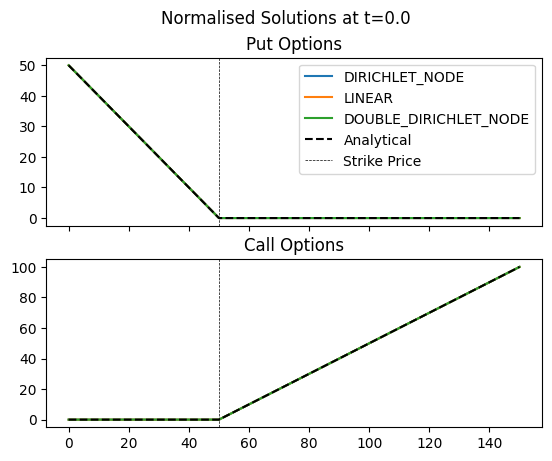

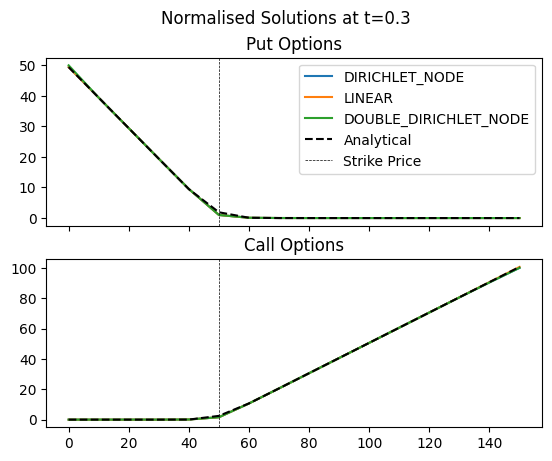

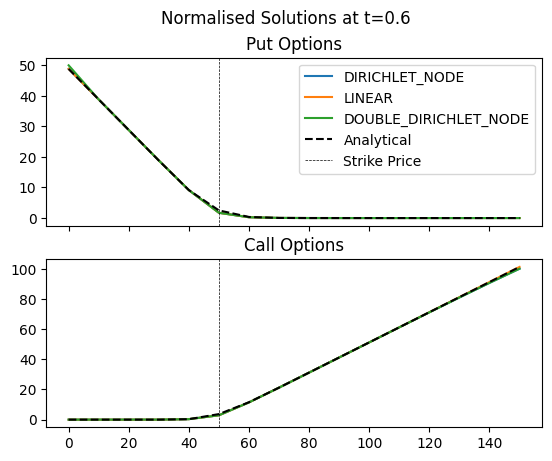

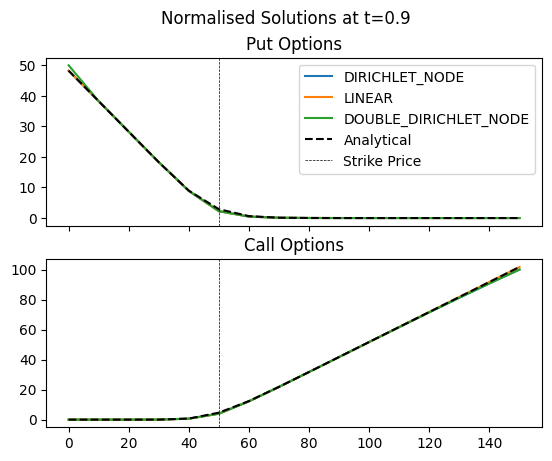

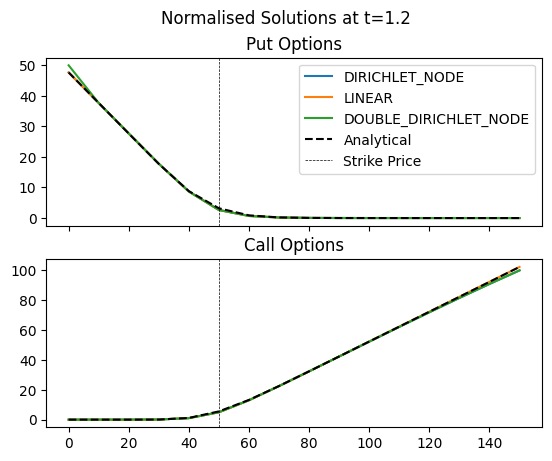

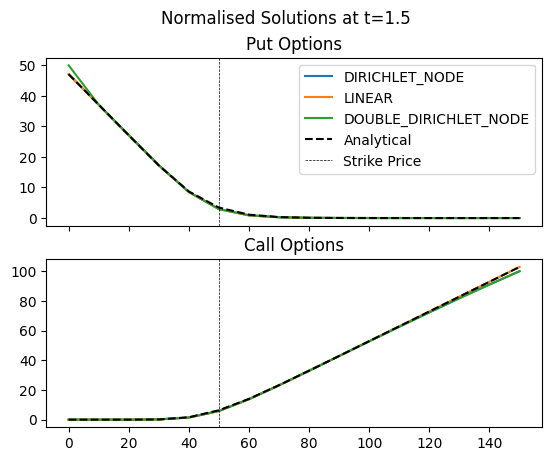

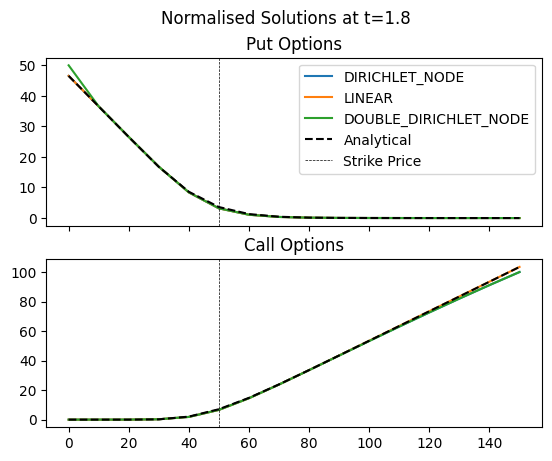

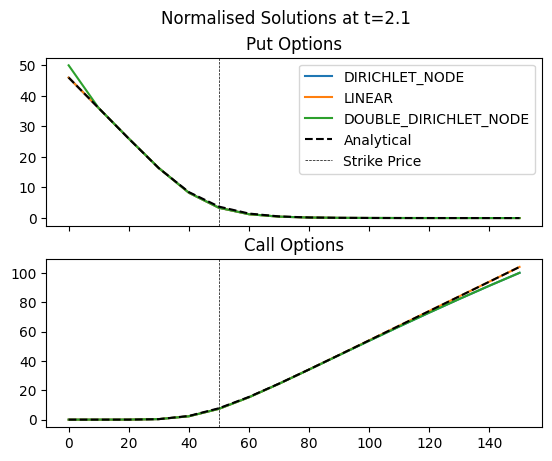

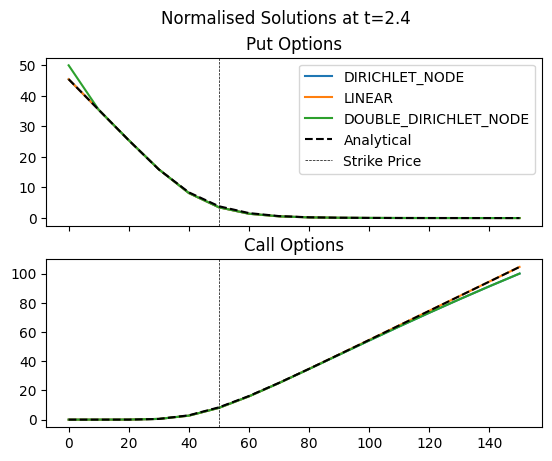

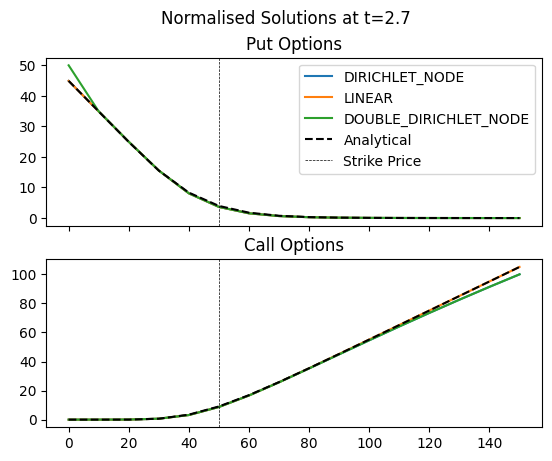

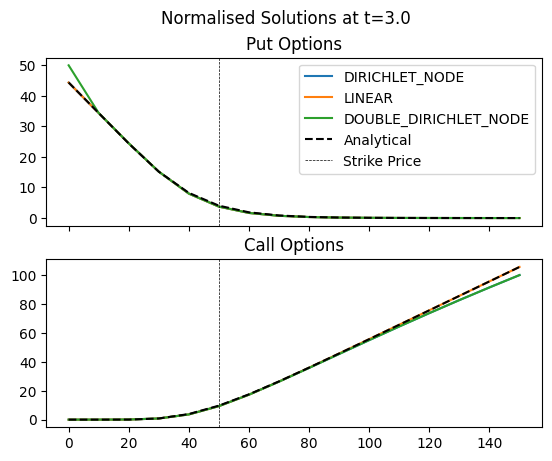

In [18]:
for ti in range(0,Nt+1,100):
    fig,axs = plt.subplots(2,1,sharex=True)
    for i,BC in enumerate(BoundaryConditions):
        if BC in [BoundaryConditions.PDE, BoundaryConditions.ZERO_AFTER]:
            continue
        axs[0].plot(x,np.abs((sol:=solutionsPut[i,ti,:])), label=BoundaryConditions(i).name)
        axs[1].plot(x,np.abs((sol:=solutionsCal[i,ti,:])), label=BoundaryConditions(i).name)
    axs[0].plot(x,PSolsAnalytical[Nt-ti,:],label='Analytical', linestyle='dashed',color='k')
    axs[1].plot(x,CSolsAnalytical[Nt-ti,:],label='Analytical', linestyle='dashed',color='k')
    axs[0].axvline(x=K,linestyle='dashed',color='black',linewidth=0.5,label='Strike Price')
    axs[1].axvline(x=K,linestyle='dashed',color='black',linewidth=0.5)
    axs[0].legend()
    fig.suptitle(f'Normalised Solutions at t={ti*dt}')
    axs[0].set_title('Put Options')
    axs[1].set_title('Call Options')
    plt.show()

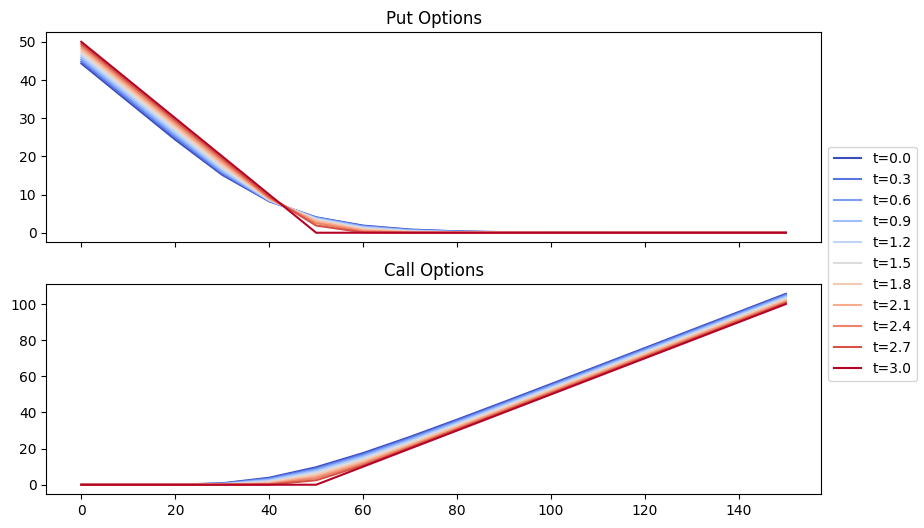

In [33]:
cmap = plt.get_cmap('coolwarm')

fig,axs = plt.subplots(2,1,sharex=True,figsize=(10,6))
axs[0].set_title('Put Options')
axs[1].set_title('Call Options')
for ti,t in list(enumerate(np.linspace(0.0,T,Nt+1)))[::100]:
    l, = axs[0].plot(x, PSolsAnalytical[ti,:], label=f't={t:0.1f}', color=cmap(t/T))
    axs[1].plot(x, CSolsAnalytical[ti,:], color=l.get_color())
fig.legend(loc='center right')
plt.show()

In [37]:
a0 = (CSolsAnalytical[0,-1] - CSolsAnalytical[0,-2]) / dS
b0 = CSolsAnalytical[0,-1] - Smax*a0

print(c:=CSolsAnalytical[::100,-1][::-1])

a = np.zeros(c.shape[0])
b = np.zeros(c.shape[0])

for ti,t in enumerate(list((np.linspace(0.0,T,Nt+1)))[::100]):
    a[ti] = 1.0
    b[ti] = b0*np.exp(r*t)

print((a*Smax + b)[::-1])

[100.         100.59641436 101.18571451 101.76798533 102.34331092
 102.91177781 103.47348518 104.02855611 104.57713879 105.11939698
 105.65549663]
[100.0300325  100.62608862 101.21503481 101.79695589 102.37193564
 102.94005687 103.50140138 104.05605002 104.60408264 105.14557818
 105.6806146 ]


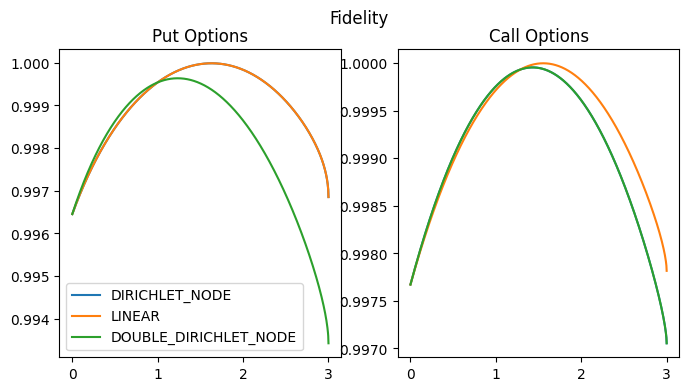

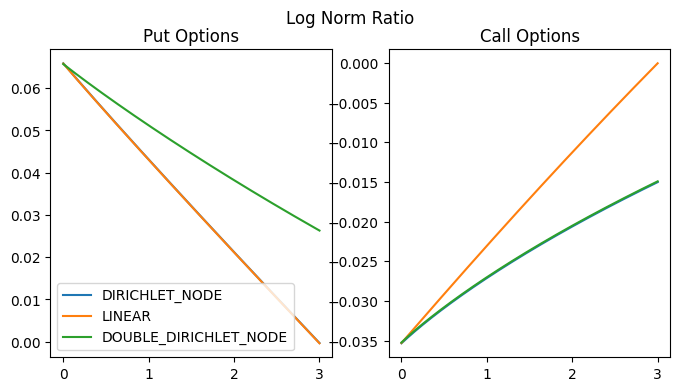

In [19]:
fidelity = np.zeros((2,len(BoundaryConditions),Nt+1))
for i,BC in enumerate(BoundaryConditions):
    for ti,t in enumerate(np.linspace(0.0,T,Nt+1)):
        fidelity[0,i,ti] = np.dot( np.abs(solutionsPut[i,ti,:]/np.linalg.norm(solutionsPut[i,ti,:])), PSolsAnalytical[ti,:]/np.linalg.norm(PSolsAnalytical[ti,:]) )
        fidelity[1,i,ti] = np.dot( np.abs(solutionsCal[i,ti,:]/np.linalg.norm(solutionsCal[i,ti,:])), CSolsAnalytical[ti,:]/np.linalg.norm(CSolsAnalytical[ti,:]) )
lognormratio = np.zeros((2,len(BoundaryConditions),Nt+1))
for i,BC in enumerate(BoundaryConditions):
    for ti,t in enumerate(np.linspace(0.0,T,Nt+1)):
        lognormratio[0,i,ti] = np.log10( np.linalg.norm(solutionsPut[i,ti,:]) / np.linalg.norm(PSolsAnalytical[i,:]) )
        lognormratio[1,i,ti] = np.log10( np.linalg.norm(solutionsCal[i,ti,:]) / np.linalg.norm(CSolsAnalytical[i,:]) )
fig,axs = plt.subplots(1,2,sharex=True,figsize=(8,4))
for i,BC in enumerate(BoundaryConditions):
    if BC in [BoundaryConditions.PDE, BoundaryConditions.ZERO_AFTER]:
        continue
    for j in range(2):
        axs[j].plot(t:=np.linspace(0.0,T,Nt+1),fidelity[j,i,:], label=BC.name)
fig.suptitle('Fidelity')
axs[0].set_title('Put Options')
axs[1].set_title('Call Options')
axs[0].legend()
plt.show()
fig,axs = plt.subplots(1,2,sharex=True,figsize=(8,4))
for i,BC in enumerate(BoundaryConditions):
    if BC in [BoundaryConditions.PDE, BoundaryConditions.ZERO_AFTER]:
        continue
    for j in range(2):
        axs[j].plot(t:=np.linspace(0.0,T,Nt+1),lognormratio[j,i,:], label=BC.name)
fig.suptitle('Log Norm Ratio')
axs[0].set_title('Put Options')
axs[1].set_title('Call Options')
axs[0].legend()
plt.show()